<a href="https://colab.research.google.com/github/mongoq/thesis/blob/main/skin_cancer_model_97_88_accuracy_erfi_session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Source: https://www.kaggle.com/code/ahmed121ashraf131/skin-cancer-model-97-88-accuracy/notebook**

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# download packages

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import the libraries

In [3]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [ ]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


# prepare the training plan

In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [ ]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

# training curves plot

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('/content/drive/' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [4]:
#base_skin_dir = os.path.join('..', 'input')
base_skin_dir = '/content/drive/MyDrive/ham10000-dataset/HAM10000_images_all/'
#print(base_skin_dir)

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}

#imageid_path_dict = glob(base_skin_dir + '*.jpg')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(base_skin_dir + '*.jpg')}

#print("Files: " + str(imageid_path_dict))
#print("Number of images: " + str(len(imageid_path_dict)))
#print("Type of object: " + str(type(imageid_path_dict)))

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
#data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))
data = pd.read_csv(os.path.join(base_skin_dir, "HAM10000_metadata.csv"))

label = data
# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


In [ ]:
data.isnull().any().sum()

1

# Imputing the Null values and preparing the data

In [ ]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [ ]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

KeyError: ignored

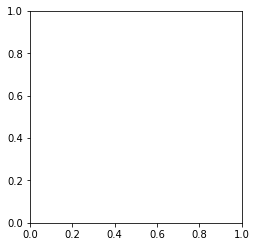

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

(10015, 13)
(45756, 13)


In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [ ]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [ ]:
model =create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 43s 90ms/step - loss: 1.6897 - accuracy: 0.4756 - val_loss: 1.0177 - val_accuracy: 0.6169 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 38s 83ms/step - loss: 0.8772 - accuracy: 0.6678 - val_loss: 0.7920 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 43s 94ms/step - loss: 0.6252 - accuracy: 0.7676 - val_loss: 0.6513 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 38s 84ms/step - loss: 0.4578 - accuracy: 0.8308 - val_loss: 0.3814 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 39s 84ms/step - loss: 0.3664 - accuracy: 0.8647 - val_loss: 0.3580 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 41s 89ms/step - loss: 0.2813 - accuracy: 0.8969 - val_loss: 0.2862 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 38s 

In [ ]:
model

# save model

In [ ]:
model.save('/content/drive/MyDrive/Skin_Cancer_Sauron_Session.sav')

# save model weights

In [ ]:
model.save_weights("/content/drive/MyDrive/Skin_Cancer_Sauron_Session.hdf5")

In [ ]:
#from IPython.display import FileLink
#FileLink('Skin_Cancer.hdf5')

/kaggle/working/Skin_Cancer.hdf5

# load model (use only if model already trained!)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
model=keras.models.load_model('/content/drive/MyDrive/Skin_Cancer_Sauron_Session.sav')

# predict / inference with single image (no diagnosis)

In [ ]:
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/
# https://github.com/housecricket/how_to_predict_an_image_with_keras/blob/master/solution.py
# https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

# Load Python packages

from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load image and convert to Array

# img = image.load_img(base_skin_dir + "ISIC_0024806.jpg", target_size=(28, 28)) # .csv => diagnosis: mel
# img_tensor = image.img_to_array(img)                    # (height, width, channels)
# img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
# img_tensor /= 255. 
 
#pred=model.predict(img_tensor)

#print("Raw Data")
#print(pred)
#print("")

# https://levelup.gitconnected.com/sorting-in-python-using-keys-d2622edd7a92

#print("Sorted by diagnosis")
#diagnoses = [('nv', pred[0][0]), ('mel', pred[0][1]), ('bkl', pred[0][2]), ('bcc', pred[0][3]), ('akiec', pred[0][4]), ('vasc', pred[0][5]), ('df', pred[0][6])]
#diagnoses.sort(reverse=True, key=lambda x: x[1])
#print(diagnoses)

# predict / inference / estimate accuracy by comparing the diagnosis (.csv)

In [ ]:
import keras

#print("All images with path:")
accuracy_measure = 0;
for key in imageid_path_dict:
  #print(imageid_path_dict[key])
  img = image.load_img(imageid_path_dict[key], target_size=(28, 28))
  img_tensor = image.img_to_array(img)                    # (height, width, channels)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
  img_tensor /= 255.
  pred=model.predict(img_tensor)
  #print("Sorted by Diagnosis")
  diagnoses = [('nv', pred[0][0]), ('mel', pred[0][1]), ('bkl', pred[0][2]), ('bcc', pred[0][3]), ('akiec', pred[0][4]), ('vasc', pred[0][5]), ('df', pred[0][6])]
  diagnoses.sort(reverse=True, key=lambda x: x[1])
  print(key)
  for x in range(len(label)):
    if(label['image_id'][x] == key):
      if(label['dx'][x] == diagnoses[0][0]):
        accuracy_measure = accuracy_measure +1;
        print("Accuracy measure: " + str(accuracy_measure));
print(accuracy_measure);

ISIC_0033322
Accuracy measure: 1
ISIC_0033323
ISIC_0033324
ISIC_0033325
ISIC_0033326
ISIC_0033327
ISIC_0033328
ISIC_0033329
ISIC_0033330
ISIC_0033331
ISIC_0033332
ISIC_0033333
ISIC_0033334
ISIC_0033335
ISIC_0033336
ISIC_0033337
ISIC_0033338
ISIC_0033339
ISIC_0033340
ISIC_0033341
ISIC_0033342
ISIC_0033343
ISIC_0033344
ISIC_0033345
ISIC_0033346
ISIC_0033347
ISIC_0033348
ISIC_0033349
ISIC_0033350
ISIC_0033351
ISIC_0033352
ISIC_0033353
ISIC_0033354
ISIC_0033355
ISIC_0033356
ISIC_0033357
ISIC_0033358
ISIC_0033359
ISIC_0033360
ISIC_0033361
Accuracy measure: 2
ISIC_0033362
ISIC_0033363
ISIC_0033364
ISIC_0033365
ISIC_0033366
ISIC_0033367
ISIC_0033368
ISIC_0033369
ISIC_0033371
ISIC_0033372
ISIC_0033370
ISIC_0033373
ISIC_0033374
ISIC_0033375
ISIC_0033377
ISIC_0033376
ISIC_0033378
Accuracy measure: 3
ISIC_0033379
Accuracy measure: 4
ISIC_0033380
ISIC_0033381
ISIC_0033382
ISIC_0033383
ISIC_0033384
ISIC_0033385
ISIC_0033386
ISIC_0033387
ISIC_0033388
ISIC_0033389
ISIC_0033390
ISIC_0033391
Accuracy m